In [1]:
import umap 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn
import torch 
import torch_geometric as pyg 
import sklearn 
import networkx as nx
import umap
from node2vec import Node2Vec

import sys 
sys.path.append('../')
import src.models.utils as utils
from src.data.LincsDataset import LincsDataset

from src.interpret.extract_entity_function import extract_entity_function
from src.interpret.GSNNExplainer import GSNNExplainer 
from src.interpret.plot_explanation_graph import plot_explanation_graph, plot_hairball

from src.prioritize.utils import get_base_X, dose2scale, set_drug_concs
from src.uncertainty.utils import root_mean_squared_picp_error, compute_picp, compute_ECE

from src.prioritize.utils import * 

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/grcp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/Data.pt')
#data = torch.load('../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/Data.pt')
model = torch.load('../output/exp1/FOLD-1/GSNN/8c62d604-d99c-48d5-9bf0-9a8e9d30c644/model-100.pt')
#model = torch.load('../output/SignalTransduction/FOLD-1/GSNN/c82456f4-6c84-4100-a83a-5d6d6d80b94d/model-100.pt')

siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [3]:
drugs = [x.split('__')[-1] for x in data.node_names if 'DRUG__' in x] # some 
cells = ['SKBR3']
doses = [0.1]

args = argparse.Namespace()
args.proc = '../output/exp1/proc/'
#args.proc = '../output/SignalTransduction/proc/'
args.combo = False
args.verbose = True

X, res = make_drug_inputs(args, data, drugs, cells, doses, siginfo)

screening 503 drugs over 1 doses
screening 2-drug combination agents: False
progress: 	SKBR3 (0/1) 	| BRD-U86686840=0.1000 	| none=0.0000)


In [4]:

model = model.cuda().eval() 
activations = [] 
with torch.no_grad(): 

    for batch_idx in torch.split(torch.arange(len(X)), 100): 
        print(f'progress: {batch_idx[-1]}/{len(X)}', end='\r')
        xx = X[batch_idx].unsqueeze(-1).cuda() 

        activations.append(model(xx, return_all_activations=True).cpu())

activations = torch.cat(activations, dim=0)

In [5]:
activations.size()

torch.Size([503, 18501, 16])

In [6]:
# average edge-activation correlation across all drugs 

edge_corr = torch.zeros(activations.size(1), activations.size(1))
for i in range(activations.size(0))[0:10]: 
    print(f'progress: {i}/{activations.size(0)}',end='\r')
    edge_corr += torch.corrcoef( activations[i, :, :] )

edge_corr /= (i + 1)


In [7]:
edge_corr.max()

tensor(1.)

In [8]:
edge_corr

tensor([[ 1.0000,  0.5722,  0.4300,  ..., -0.2420, -0.0827,  0.3143],
        [ 0.5722,  1.0000, -0.0528,  ..., -0.1732, -0.4877, -0.2938],
        [ 0.4300, -0.0528,  1.0000,  ...,  0.4519,  0.7904,  0.3745],
        ...,
        [-0.2420, -0.1732,  0.4519,  ...,  1.0000,  0.7247, -0.3045],
        [-0.0827, -0.4877,  0.7904,  ...,  0.7247,  1.0000,  0.2438],
        [ 0.3143, -0.2938,  0.3745,  ..., -0.3045,  0.2438,  1.0000]])

In [10]:
n = edge_corr.size(0)
A = (np.abs(edge_corr) > 0.99)*(torch.ones(n, n) - torch.eye(n, n))
A.sum()

tensor(78850.)

In [11]:
G = nx.from_numpy_matrix(A.detach().cpu().numpy())
len(G)

18501

In [12]:
len(G.edges())

39425

In [13]:
def graph_embedding_to_2d_pos_umap(G, dim=64, length=30, walks=200, workers=12, window=10, min_count=1, batch_words=4):
    # Create a Node2Vec model
    node2vec = Node2Vec(G, dimensions=dim, walk_length=length, num_walks=walks, workers=workers)

    # Train the model
    model = node2vec.fit(window=window, min_count=min_count, batch_words=batch_words)

    # Generate embeddings
    embeddings = model.wv

    # Retrieve node embeddings
    node_list = list(G.nodes())
    node_embeddings = [embeddings[str(node)] for node in node_list]

    # Apply UMAP for dimensionality reduction to 2D
    reducer = umap.UMAP(n_components=2)
    node_embeddings_2d = reducer.fit_transform(node_embeddings)

    # Create a pos dictionary mapping nodes to their embeddings in 2D space
    pos = {node: node_embeddings_2d[i] for i, node in enumerate(node_list)}

    return pos

In [15]:
pos = graph_embedding_to_2d_pos_umap(G, workers=24)

Generating walks (CPU: 4): 100%|██████████| 50/50 [02:24<00:00,  2.90s/it]


TypeError: Word2Vec.__init__() got an unexpected keyword argument 'size'

In [ ]:
plt.figure()
nx.draw_networkx_edges

In [7]:
reducer = umap.UMAP()
reducer.fit(np.abs(edge_corr)) #  > 0.5)*1.
u = reducer.transform(edge_corr)

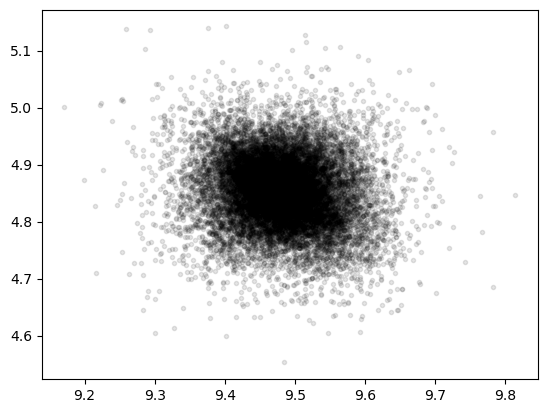

In [8]:
plt.figure()
plt.plot(u[:, 0], u[:,1], 'k.', alpha=0.1 )
plt.show()

In [11]:
A = (np.abs(edge_corr) > 0.25)
wA = edge_corr*A
G = nx.from_numpy_matrix(wA.detach().cpu().numpy())


In [13]:
G = nx.from_numpy_matrix(wA.detach().cpu().numpy())


18501

In [16]:
edge_corr0.size()

torch.Size([18501, 18501])

In [18]:
torch.triu_indices(edge_corr0.size(0),edge_corr0.size(1), 1)

tensor([[    0,     0,     0,  ..., 18498, 18498, 18499],
        [    1,     2,     3,  ..., 18499, 18500, 18500]])

In [21]:
plt.figure()
row,col = torch.triu_indices(edge_corr0.size(0),edge_corr0.size(1), 1)
plt.hist(edge_corr0[row,col].view(-1))
plt.show()